# Analisis del ancho de pico y procesado de la señal del PMT 

El objetivo de este notebook es analizar los datos temporales de la señal del PMT para obtener una idea de:
1. El ancho de los picos en función del voltaje donde miro, para seleccionar el threshold para el voltaje y determinar la frecuencia mínima a la que hay que adquirir los datos para detectar fotones.
1. Hacer un procesamiento de los datos para contar fotones, sacando los picos falsos que vienen después de cada pico.

Importo librerias

In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

Pongo matplotlib interactivo para hacer zoom en los gráficos

In [202]:
%matplotlib widget

Cargo los datos tomados con axi y sampling rate 125 MHz

In [203]:
path = "/home/tomi/Documents/academicos/facultad/tesis/tesis/data/peak_width/axi/data.pickle"
d125 = pd.read_pickle(path)
d125.attrs["sampling_rate"] = 125e6

Cargo los datos tomados con acq y decimations de 1 a 4 (o sea, 2^1, 2^2 ... )

In [204]:
data = [d125]
for decimation in range(2, 6):
    path = f"/home/tomi/Documents/academicos/facultad/tesis/tesis/data/27-03/peak_width_decimation/{decimation}"
    df = pd.DataFrame()
    for filename in os.listdir(path):
        screen = pd.read_pickle(f"{path}/{filename}")
        df = pd.concat([df, screen], ignore_index=True)
        df.attrs = screen.attrs
    print(screen.attrs)
    data.append(df)

{'timestamp': '2023-10-01T07:06:40.096629+00:00', 'FPGA Unique DNA': 9768337293019220, 'FPGA Synthesized ID': 1, 'Library Version': '2.00-23 (43f2d6cd9)', 'decimation': 2, 'sampling_rate': 62500000.0, 'trace_duration': 0.000262144, 'trigger_delay': 0.00234, 'trigger_delay_samples': 146250.0, 'source': 'ch2', 'level': 1.0, 'positive_edge': False}
{'timestamp': '2023-10-01T07:06:51.269490+00:00', 'FPGA Unique DNA': 9768337293019220, 'FPGA Synthesized ID': 1, 'Library Version': '2.00-23 (43f2d6cd9)', 'decimation': 4, 'sampling_rate': 31250000.0, 'trace_duration': 0.000524288, 'trigger_delay': 0.00468, 'trigger_delay_samples': 146250.0, 'source': 'ch2', 'level': 1.0, 'positive_edge': False}
{'timestamp': '2023-10-01T07:07:04.096911+00:00', 'FPGA Unique DNA': 9768337293019220, 'FPGA Synthesized ID': 1, 'Library Version': '2.00-23 (43f2d6cd9)', 'decimation': 8, 'sampling_rate': 15625000.0, 'trace_duration': 0.001048576, 'trigger_delay': 0.00936, 'trigger_delay_samples': 146250.0, 'source': '

Para cada decimación grafico y busco los distintos tipos de picos para sacarle foto y pegarla más abajo

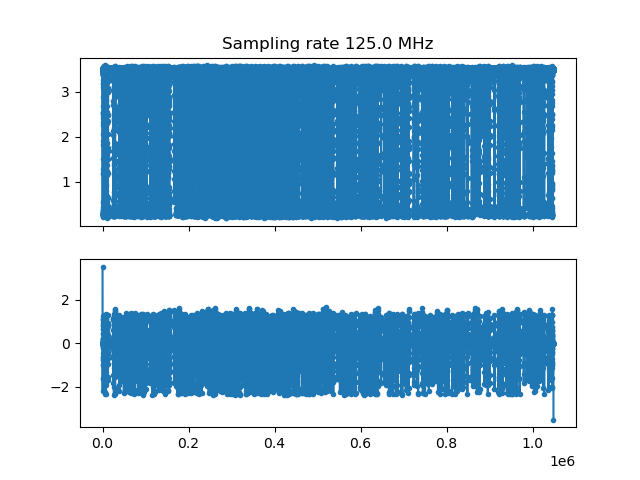

In [348]:
%matplotlib widget
plt.close('all')
d = data[0]
sr = d.attrs["sampling_rate"] * 1e-6
fig, axs = plt.subplots(2, 1, sharex=True)
ax1, ax2 = axs
ax1.set_title(f"Sampling rate {sr} MHz")
ax1.plot(d["ch1"], '.-')
kernel = [1, -1]

ax2.plot(np.convolve(d["ch1"], kernel), '.-')
plt.show()

Observando el gráfico a ojo veo que hay dos tipos principales de picos:

Estos son los mas frecuentes

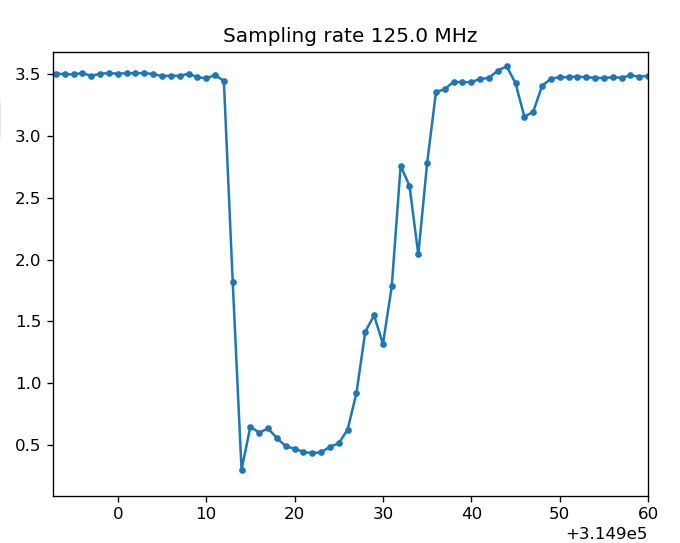

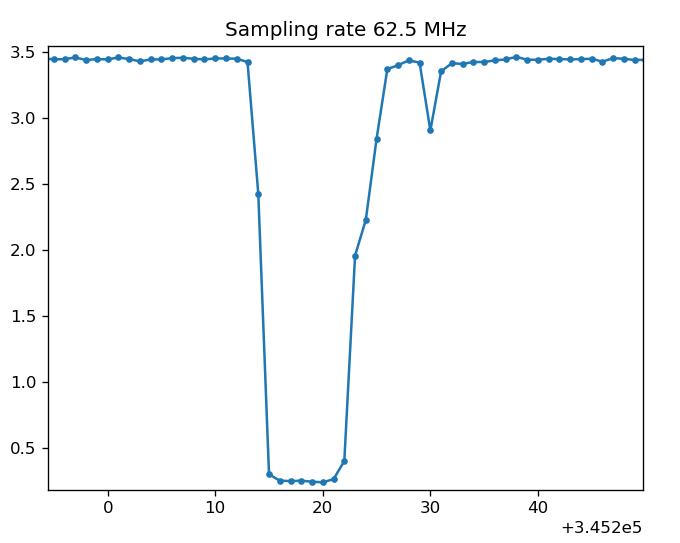

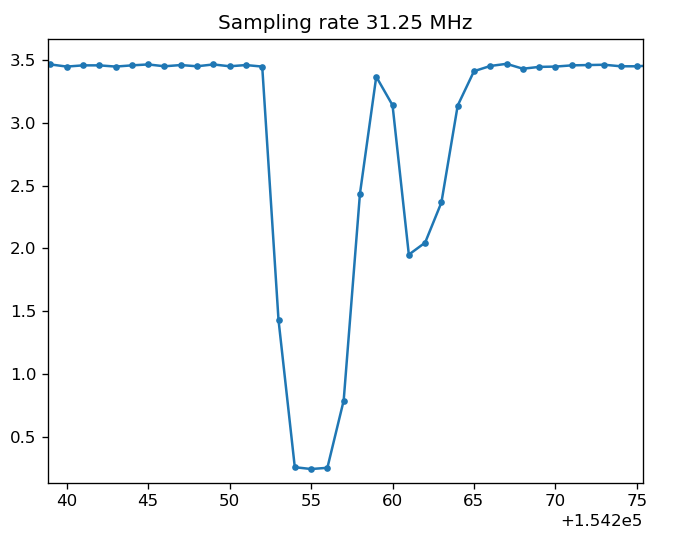

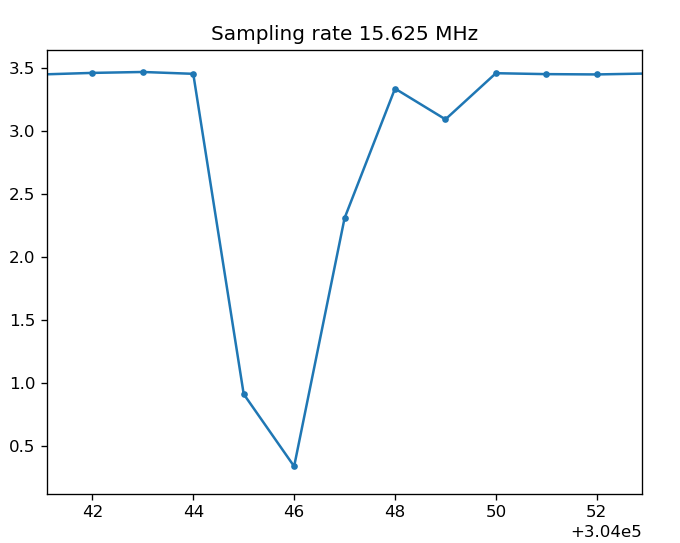

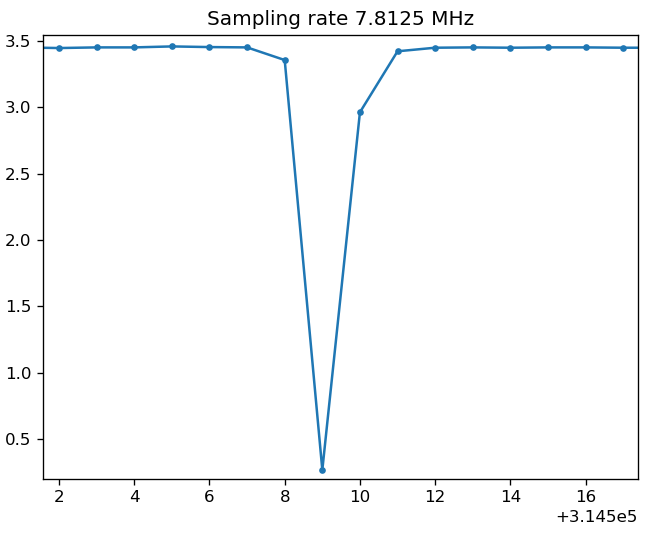

y estos menos frecuentes

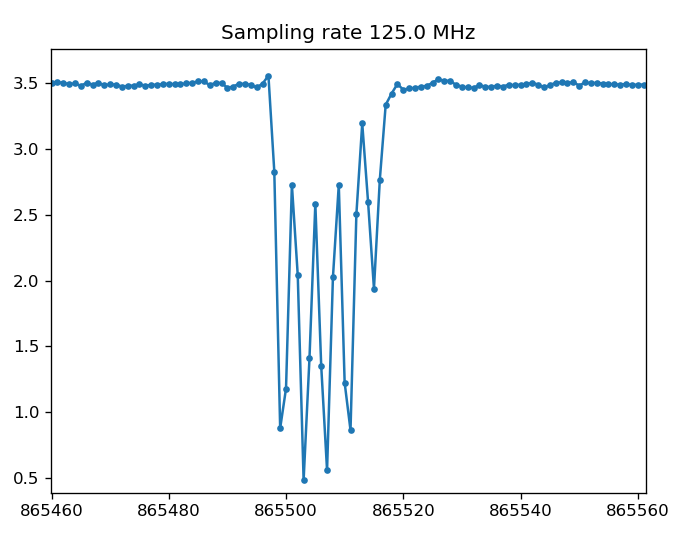

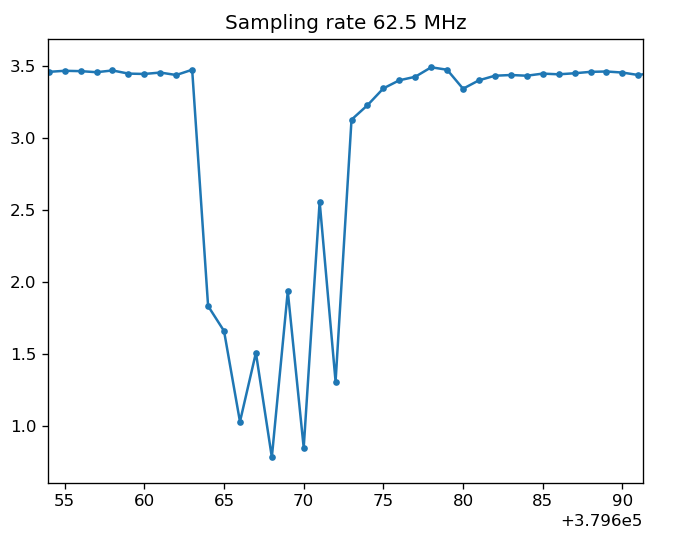

no pude encontrar picos menos frecuentes para sampling rates menores.
Se deben deformar mucho.
Sospecho que los primeros son los que estan bien y los segundos son algún tipo de ruido/artefacto del PMT.


1. distribución de alturas de los puntos de medición
1. distribución de alturas de la derivada
1. distribución de anchos en función de la altura
1. distribución de distancia hasta el próximo pico (derivada) en función de la altura

# Alturas puntos de medición


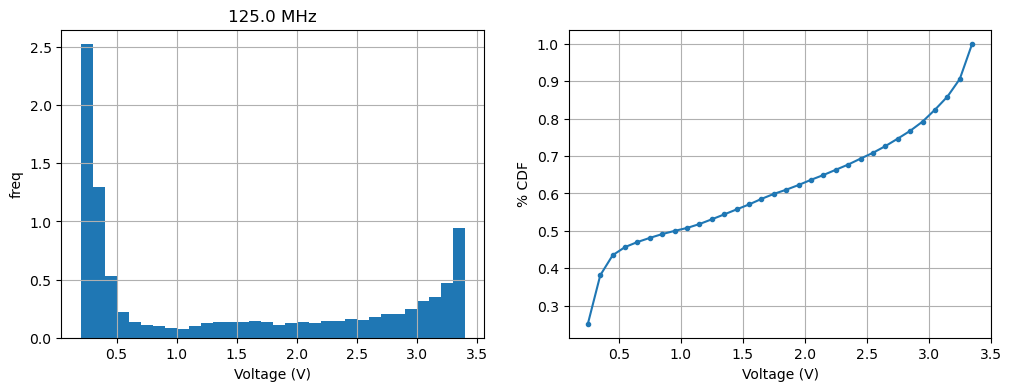

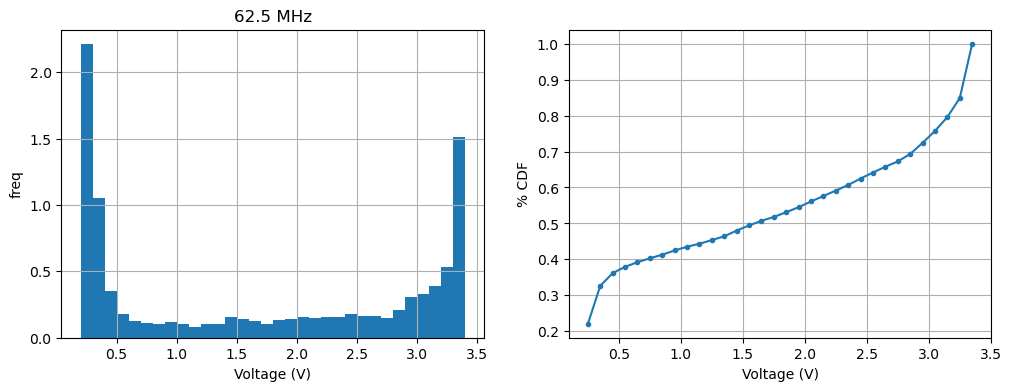

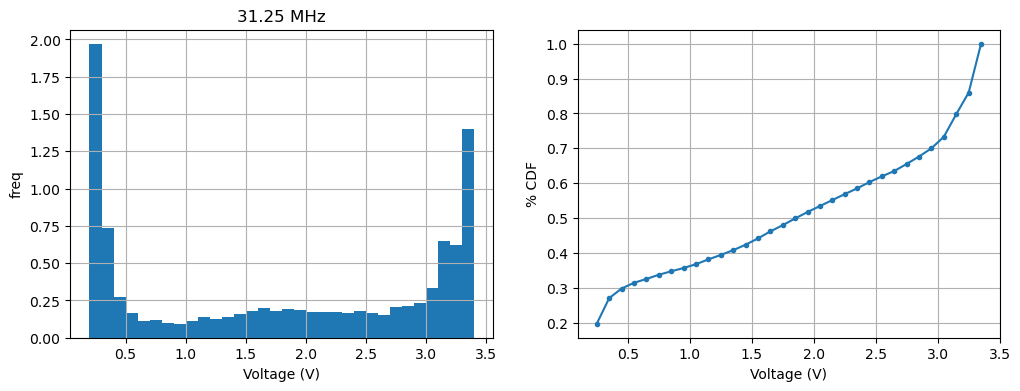

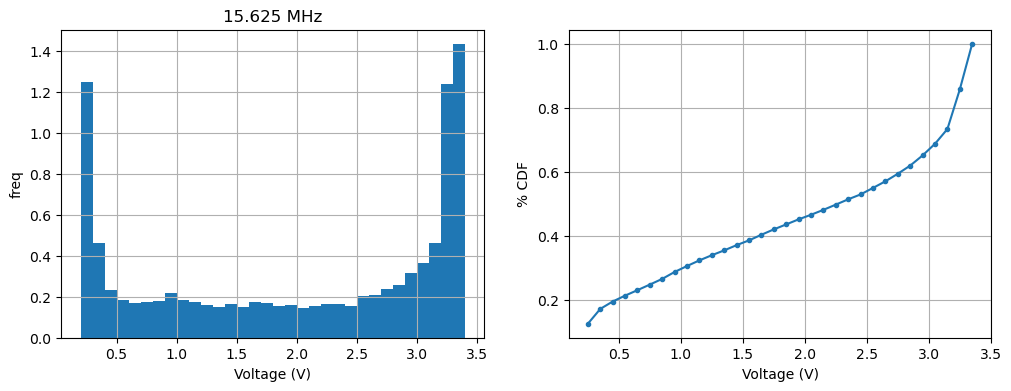

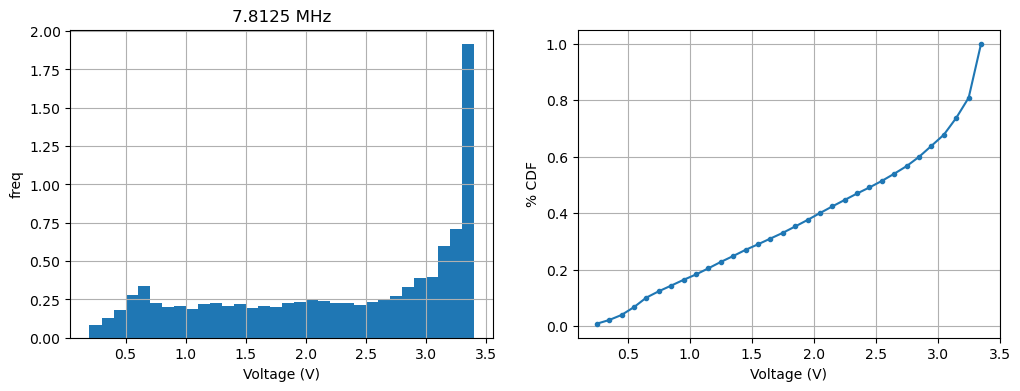

In [206]:
# Genero los bins
# defino voltage máximo
%matplotlib inline

max_voltage = 3.4
plt.close('all')
for df in data:
    df = df["ch1"][df["ch1"] < max_voltage]
    bins = np.arange(max_voltage, 0.1, -0.1)[::-1]

    freq, bin_edges = np.histogram(df, bins=bins, density=True)

    sr = df.attrs["sampling_rate"] * 1e-6
    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    ax0, ax1 = axs
    ax0.set_title(f"{sr} MHz")
    ax0.stairs(freq, bin_edges, fill=True)
    ax0.set_ylabel("freq")
    ax0.set_xlabel("Voltage (V)")
    bin_width = (bin_edges[1]-bin_edges[0])
    x = np.cumsum(np.diff(bin_edges)) + bin_edges[0] - bin_width/2
    ax1.plot(x, np.cumsum(freq)*bin_width, '.-')
    ax1.set_ylabel("% CDF")
    ax1.set_xlabel("Voltage (V)")
    ax1.grid()
    ax0.grid()
    plt.show()


Para las primeras 3 frecuencias (las que yo a ojo creo que son las mejores para detectar los picos) se ven picos para voltajes menores a 1.0 y entre 3.0 y 3.4.
Entre 1.0 y 3.0 la frecuencia es aproximadamente constante alrededor de 0.25.
Creo que lo importante para detectar los picos es que se vea el codo que se ve en los primeros 3 gráficos de la CDF.

# Distribución derivada

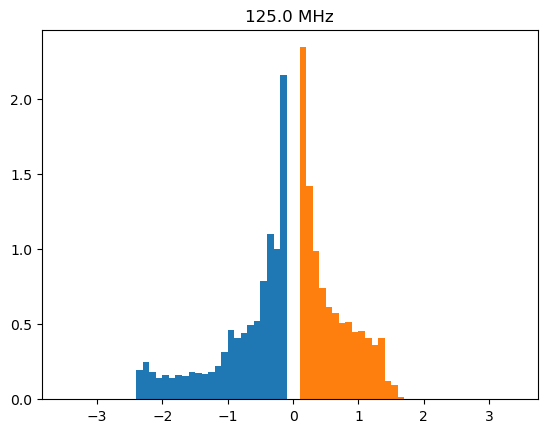

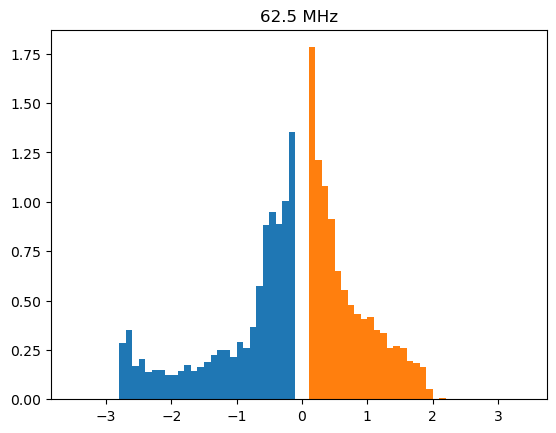

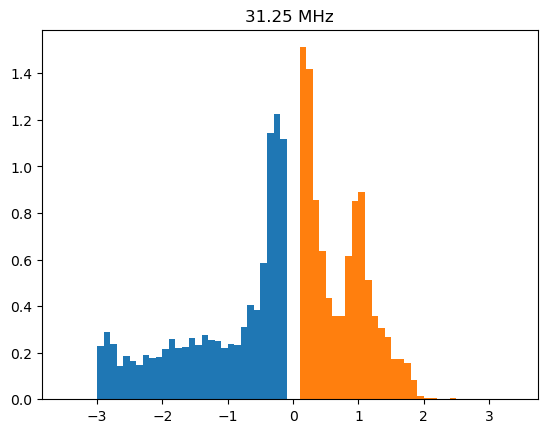

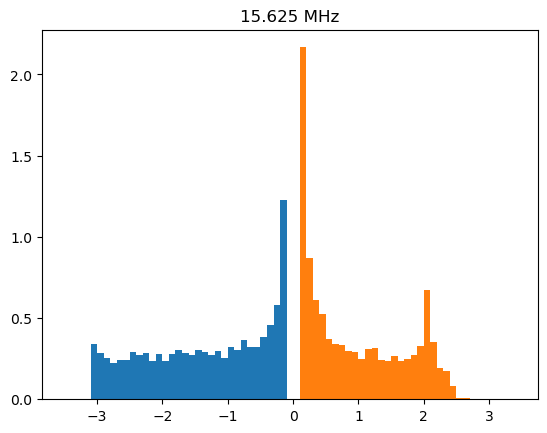

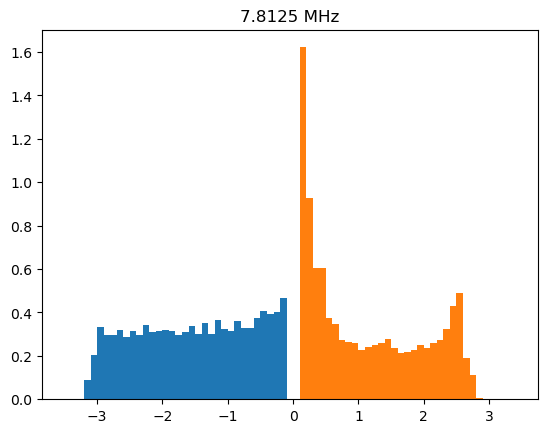

In [236]:

%matplotlib inline

max_voltage = 3.4
max_deriv_abs = 0.08
plt.close('all')
for df in data:
    kernel = [1, -1]
    ddf = np.convolve(df["ch1"], kernel)
    neg, pos = ddf[ddf < -max_deriv_abs], ddf[ddf > max_deriv_abs]
    bneg = np.arange(-3.5, 0.0, 0.1)
    bpos = np.arange(0.1, 3.5, 0.1)

    fneg, beneg = np.histogram(neg, bins=bneg, density=True)
    fpos, bepos = np.histogram(pos, bins=bpos, density=True)

    sr = df.attrs["sampling_rate"] * 1e-6

    plt.title(f"{sr} MHz")
    plt.stairs(fneg, bneg, fill=True)
    plt.stairs(fpos, bpos, fill=True)
    plt.show()

Acá hay un par de cosas destacables. 
Primero, se ve un pico bastante marcado para la frecuencia de 62 MHz para voltajes menores a -2. 
También se ve un poco para 125 y 31, pero creo que en 62 se ve mejor porque no se samplean tantos puntos intermedios entre que arrancó a subir el pico y que está arriba como en 125 (por eso en 125 es mas chata la distribución).
Por otro lado, en 31 si bien se ve el pico en -3, parece opacado por una panza que aparece alrededor de -2.
Además de esa panza, en 31 aparece un pico en 1 V que no estaba antes en 62 ni 125.
Yo creo que esto tiene que ver (no se cómo) con la desaparición de las oscilaciones en la señal (los picos raros) que había mostrado antes.
A menores sampling rates el pico en -3 desaparece y el pico positivo en 1 empieza a correrse a la derecha.

# Anchos en función del voltaje

Defino función para medir ancho

In [209]:

def get_widths(signal, level):
    widths = []
    i = 0
    length = len(signal)
    while i < length-1:
        peak_width = 0
        dp = signal[i]
        while dp < level and i < length-1:
            peak_width += 1
            i += 1
            dp = signal[i]
        if peak_width > 0:
            widths.append(peak_width)
        i += 1
    return np.array(widths)

In [210]:
levels = np.linspace(0, 3.4, 10)
widths_total = []
for df in data:
    widths_df = []
    for level in levels:
        widths = get_widths(df["ch1"], level)
        widths_df.append(widths)
    widths_total.append(widths_df)

/usr/lib64/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


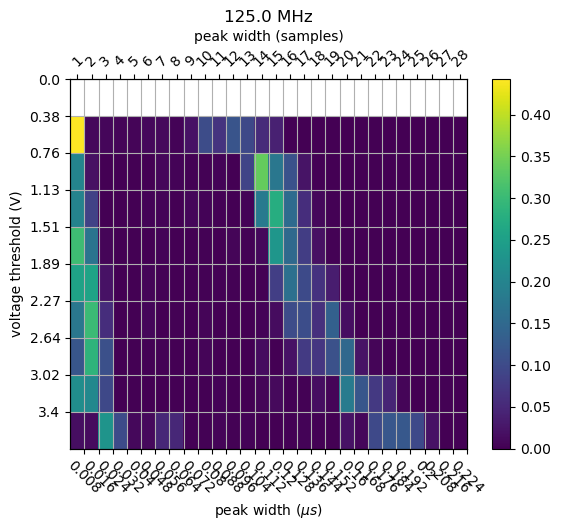

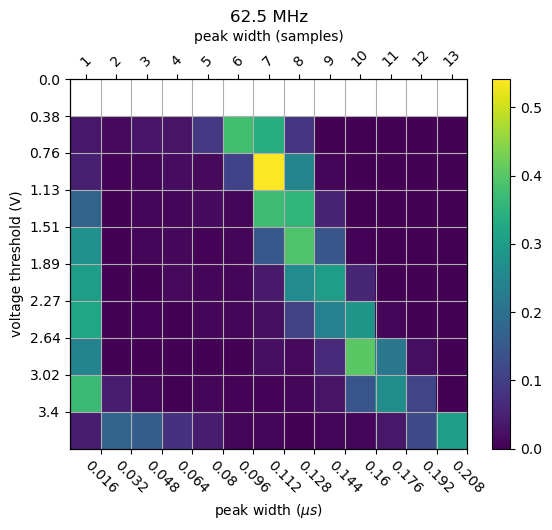

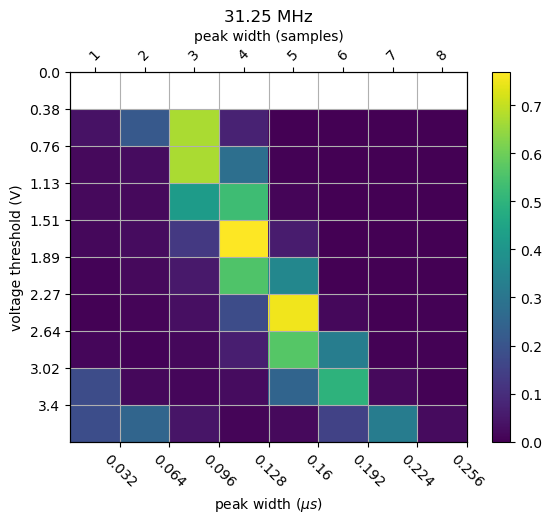

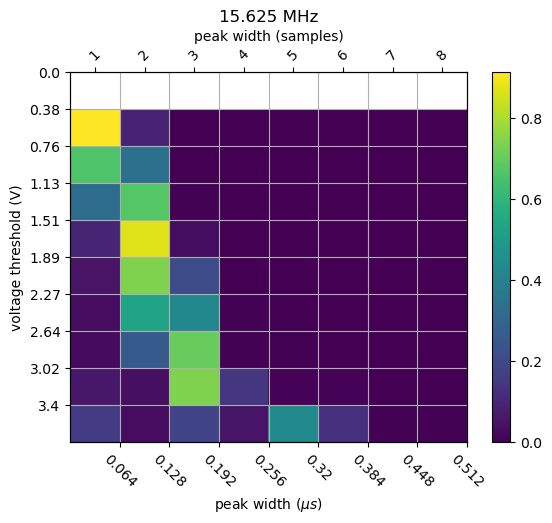

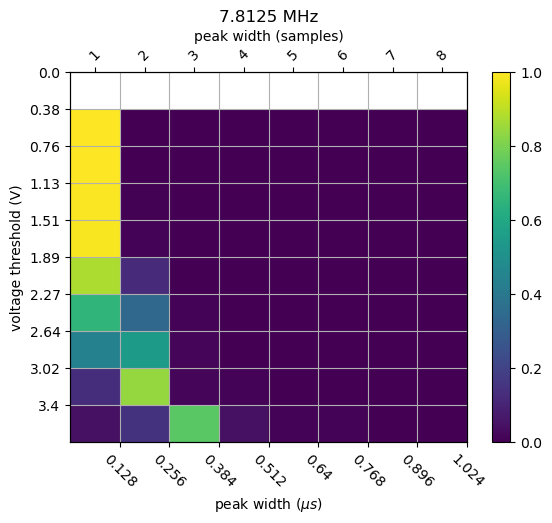

In [211]:

%matplotlib inline
import matplotlib.colors as colors

lvls = [round(lv, 2) for lv in levels]
plt.close('all')
max_bin = [30, 15, 10, 10, 10]
srs = [df.attrs["sampling_rate"] for df in data]
for i, width_df in enumerate(widths_total):
    bins = np.arange(1, max_bin[i], 1)
    freqs = []
    for width_level in width_df:
        freq, bin_edges = np.histogram(width_level, bins=bins, density=True)
        freqs.append(freq)

    fig, ax1 = plt.subplots()
    im = ax1.imshow(freqs, aspect='auto')#, vmin=0, vmax=1)
    yticks = np.arange(len(freqs)) - 0.5
    ax1.set_yticks(ticks=yticks, labels=lvls)
    xticks = np.arange(len(freqs[0])) + 0.5
    xlbls = np.round(bin_edges[:-1] /srs[i] * 1e6, 3)
    ax1.set_xticks(ticks=xticks, labels=xlbls, rotation=-45)
    ax1.set_title(f"{srs[i] * 1e-6} MHz")
    ax1.set_xlabel("peak width ($\mu s$)")
    ax1.set_ylabel("voltage threshold (V)")

    ax2 = ax1.twiny()
    ax2.set_xticks(ax1.get_xticks() - 0.5)
    ax2.set_xticklabels(bin_edges[:-1], rotation=45)
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xlabel("peak width (samples)")

    ax1.grid()
    plt.colorbar(im)
    plt.show()



Con estos gráficos queda en evidencia que las únicas frecuencias razonables para medir son 125, 62 o 31. 
Para las frecuencias menores ya es muy probable tener picos de 1 sample, así que probablemente hay picos que se perdieron.

# Distribución de distancia derivada

Ahora defino una función para encontrar los picos de los fotones.
Lo que hago es calcular una convolución entre los datos y un kernel, de lo resultante obtener los índices en los que el valor es menor a un threshold, y por último eliminar los puntos pegados en los que se cumple la condición.
El kernel, el threshold y el sampling rate de los datos que le pase a esta función va a definir una forma de contar fotones.
Debería encontrar la "mejor forma" de contar los fotones.
Para esto se me ocurren dos cosas que toman como **hipótesis que la probabilidad de contar un fotón en un intervalo de tiempo a una intensidad y con este PMT es poisson**.
En ese caso, podría determinar el mejor criterio para contar fotones barriendo todos los criterios y encontrar el que mejor ajuste:
1. Los datos subsampleados en distintos intervalos por una poisson proporcional al intervalo.
1. La distancia entre fotones por una exponencial. 

**No confío del todo en las mediciones que tengo para hacer esto. Podría repetirlas teniendo este objetivo en cuenta.**

In [349]:
def find_edges(data, threshold, kernel=(1,-1), clean=True):
    dd = np.convolve(data, kernel)
    edges = np.where(dd < threshold)[0]

    if clean:
        e_prev=0
        for i, e in enumerate(edges):
            if e-e_prev < 2:
                edges[i] = -1
            e_prev = e
        edges = edges[edges >= 0]
    return edges

In [ ]:
plt.close('all')
d = data[1]
is_poisson = []
mes_interval = 10000
for i in range(10000):
    i0 = np.random.randint(0, len(d) - mes_interval)
    edges = find_edges(d.iloc[i0: i0+mes_interval]["ch1"], -1, kernel=(1, -1))
    is_poisson.append(len(edges))

bins = np.arange(0, 40)
freq, bin_edges = np.histogram(is_poisson, bins=bins)
plt.stairs(freq, bin_edges, fill=True)
plt.xticks(bins[::2])
plt.show()

Jugando un poco con los valores de la celda de arriba, se ve que el comportamiento promedio parece poisson, pero hay algunos artefactos extraños que tengo que explorar.